# EDA for Loan Prediction
***
***

__[Analysis by :: Rishabh Saxena](https://www.linkedin.com/in/saxena-rishabh/)__

### Table of Contents
[I. Import Libraries and set required parameters](#library)

[II. Data Sourcing](#sourcing)

[III. Data Cleaning and Manipulation](#cleaning)

[IV. Univariate Analysis](#univariate)

[V. Bivariate/Multivariate Analysis](#bivariate)

[VI. Bivariate/Multivariate Analysis with Probability of Charged off](#bivariate_prob)

[VII. Conclusion](#Conclusion)

## I. Import Libraries and set required parameters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

# Regular expressions
import re

# seaborn : advanced visualization
import seaborn as sns

pd.options.mode.chained_assignment = None 
pd.options.display.float_format = '{:.4f}'.format 
pd.set_option('display.max_columns', 100) 

np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format})

import os

import warnings
warnings.filterwarnings('ignore') 

## II. Data Sourcing

In [2]:
loan = pd.read_excel("loan.xlsx")
print(loan.shape)

(39717, 111)


In [3]:
loan.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,...,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0000,36 months,0.1065,162.8700,B,B2,NaN,10+ years,RENT,24000.0000,Verified,2011-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.6500,0,1985-01-01,1,nan,nan,3,0,13648,0.8370,9,f,0.0000,0.0000,5863.1552,5833.8400,5000.0000,863.1600,0.0000,0.0000,0.0000,2015-01-01,171.6200,NaT,2016-05-01,0.0000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0000,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0000,0.0000,nan,nan,nan,nan
1,1077430,1314167,2500,2500,2500.0000,60 months,0.1527,59.8300,C,C4,Ryder,< 1 year,RENT,30000.0000,Source Verified,2011-12-01,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.0000,0,1999-04-01,5,nan,nan,3,0,1687,0.0940,4,f,0.0000,0.0000,1008.7100,1008.7100,456.4600,435.1700,0.0000,117.0800,1.1100,2013-04-01,119.6600,NaT,2013-09-01,0.0000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0000,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0000,0.0000,nan,nan,nan,nan


**List of Columns & NA counts where NA values are more than 30%**

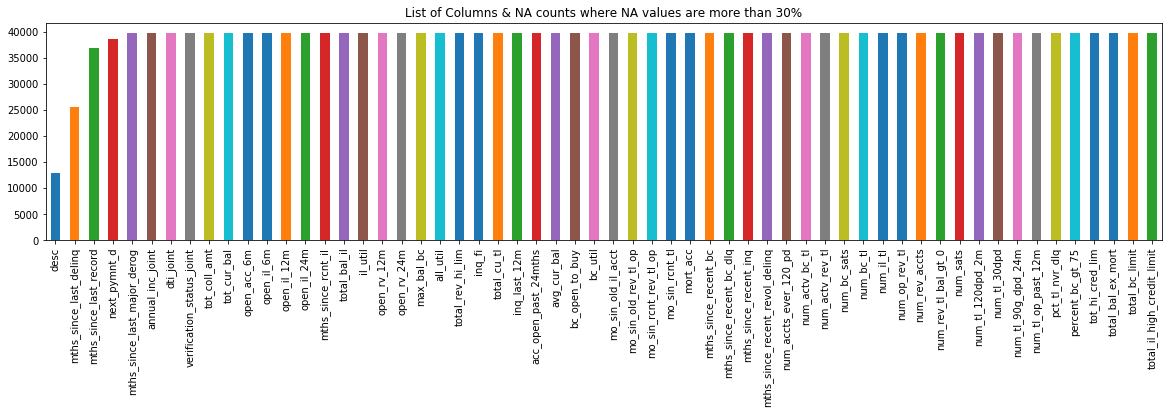

In [4]:
NA_col = loan.isnull().sum()
NA_col = NA_col[NA_col.values >(0.3*len(loan))]
plt.figure(figsize=(20,4))
NA_col.plot(kind='bar')
plt.title('List of Columns & NA counts where NA values are more than 30%')
plt.show()

**Insights: So we can see from the above plot that there are 50+ columns in the dataset where the values are NA.**

As we can see there are **39717** rows & **111** columns in the dataset, it will be very difficult to look at each column one by one & find the NA or missing values.
So let's find out all columns where missing values are more than certain percentage, let's say **30%**. We will remove those columns as it is not feasable to impute missing values for those columns.

We will create a UDF for this.

## III. Data Cleaning and Manipulation

**UDF :: removeNulls(dataframe, axis, percent)**  
**removeNulls(dataframe, axis, percent) will drop the columns/rows from the dataset based on the parameter values.**

In [5]:
def removeNulls(dataframe, axis =1, percent=0.3):
    '''
    * removeNull function will remove the rows and columns based on parameters provided.
    * dataframe : Name of the dataframe  
    * axis      : axis = 0 defines drop rows, axis =1(default) defines drop columns    
    * percent   : percent of data where column/rows values are null,default is 0.3(30%)
              
    '''
    df = dataframe.copy()
    ishape = df.shape
    if axis == 0:
        rownames = df.transpose().isnull().sum()
        rownames = list(rownames[rownames.values > percent*len(df)].index)
        df.drop(df.index[rownames],inplace=True) 
        print("\nNumber of Rows dropped\t: ",len(rownames))
    else:
        colnames = (df.isnull().sum()/len(df))
        colnames = list(colnames[colnames.values>=percent].index)
        df.drop(labels = colnames,axis =1,inplace=True)        
        print("Number of Columns dropped\t: ",len(colnames))
        
    print("\nOld dataset rows,columns",ishape,"\nNew dataset rows,columns",df.shape)

    return df

#### 1. Remove columns where NA values are more than or equal to 30%

In [6]:
loan = removeNulls(loan, axis =1,percent = 0.3)

Number of Columns dropped	:  58

Old dataset rows,columns (39717, 111) 
New dataset rows,columns (39717, 53)


#### 2. Remove rows where NA values are more than or equal to 30%
(Note: NA columns has already been removed in step 1, so we may not find any <b>rows</b> where 30% values are NA)

In [7]:
loan = removeNulls(loan, axis =0,percent = 0.3)


Number of Rows dropped	:  0

Old dataset rows,columns (39717, 53) 
New dataset rows,columns (39717, 53)


#### 3. Remove columns where number of unique value is only 1.

Let's look at no of unique values for each column.We will remove all columns where number of unique value is only 1 because that will not make any sense in the analysis

In [8]:
unique = loan.nunique()
unique = unique[unique.values == 1]

In [9]:
print(unique)

pymnt_plan                    1
initial_list_status           1
collections_12_mths_ex_med    1
policy_code                   1
application_type              1
acc_now_delinq                1
chargeoff_within_12_mths      1
delinq_amnt                   1
tax_liens                     1
dtype: int64


In [10]:
loan.drop(labels = list(unique.index), axis =1, inplace=True)
print("So now we are left with",loan.shape ,"rows & columns.")

So now we are left with (39717, 44) rows & columns.


In [11]:
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
0,1077501,1296599,5000,5000,4975.0000,36 months,0.1065,162.8700,B,B2,NaN,10+ years,RENT,24000.0000,Verified,2011-12-01,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Computer,860xx,AZ,27.6500,0,1985-01-01,1,3,0,13648,0.8370,9,0.0000,0.0000,5863.1552,5833.8400,5000.0000,863.1600,0.0000,0.0000,0.0000,2015-01-01,171.6200,2016-05-01,0.0000
1,1077430,1314167,2500,2500,2500.0000,60 months,0.1527,59.8300,C,C4,Ryder,< 1 year,RENT,30000.0000,Source Verified,2011-12-01,Charged Off,https://lendingclub.com/browse/loanDetail.acti...,car,bike,309xx,GA,1.0000,0,1999-04-01,5,3,0,1687,0.0940,4,0.0000,0.0000,1008.7100,1008.7100,456.4600,435.1700,0.0000,117.0800,1.1100,2013-04-01,119.6600,2013-09-01,0.0000
2,1077175,1313524,2400,2400,2400.0000,36 months,0.1596,84.3300,C,C5,NaN,10+ years,RENT,12252.0000,Not Verified,2011-12-01,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,small_business,real estate business,606xx,IL,8.7200,0,2001-11-01,2,2,0,2956,0.9850,10,0.0000,0.0000,3005.6668,3005.6700,2400.0000,605.6700,0.0000,0.0000,0.0000,2014-06-01,649.9100,2016-05-01,0.0000
3,1076863,1277178,10000,10000,10000.0000,36 months,0.1349,339.3100,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0000,Source Verified,2011-12-01,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,other,personel,917xx,CA,20.0000,0,1996-02-01,1,10,0,5598,0.2100,37,0.0000,0.0000,12231.8900,12231.8900,10000.0000,2214.9200,16.9700,0.0000,0.0000,2015-01-01,357.4800,2016-04-01,0.0000
4,1075358,1311748,3000,3000,3000.0000,60 months,0.1269,67.7900,B,B5,University Medical Group,1 year,RENT,80000.0000,Source Verified,2011-12-01,Current,https://lendingclub.com/browse/loanDetail.acti...,other,Personal,972xx,OR,17.9400,0,1996-01-01,0,15,0,27783,0.5390,38,524.0600,524.0600,3513.3300,3513.3300,2475.9400,1037.3900,0.0000,0.0000,0.0000,2016-05-01,67.7900,2016-05-01,0.0000


In [12]:
loan.isnull().sum()

id                            0
member_id                     0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_title                  2459
emp_length                 1075
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
url                           0
purpose                       0
title                        12
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                   50
total_acc                     0
out_prnc

#### 4. emp_title : Replace 'n/a' value with 'unknown'.

There are some values in emp_title which are <b>'n/a'</b>, so we replace them with <b>'unknown'</b>.

In [13]:
print(loan.emp_title.unique())
loan.emp_title.fillna('unknown',inplace=True)
loan.emp_title.replace(['n/a'],'unknown',inplace=True)
print(loan.emp_title.unique())

[nan 'Ryder' 'AIR RESOURCES BOARD' ... 'FiSite Research'
 'Squarewave Solutions, Ltd.' 'Evergreen Center']
['unknown' 'Ryder' 'AIR RESOURCES BOARD' ... 'FiSite Research'
 'Squarewave Solutions, Ltd.' 'Evergreen Center']


#### 5. emp_length : Replace 'n/a' value with '0 year'.

There are some values in emp_length which are <b>'n/a'</b>, so we replace them with <b>'0 year'</b>.

In [14]:
print(loan.emp_length.unique())
loan.emp_length.fillna('0 year',inplace=True)
loan.emp_length.replace(['n/a'], '0 year' ,inplace=True)
print(loan.emp_length.unique())

['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' nan]
['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' '0 year']


#### 6. title : Replace 'n/a' value with 'Other'.

There are some values in title which are <b>'n/a'</b>, so we replace them with <b>'Other'</b>.

In [15]:
print(loan.title.unique())
loan.title.fillna('Other',inplace=True)
loan.title.replace(['n/a'],'Other',inplace=True)
print(loan.title.unique())

['Computer' 'bike' 'real estate business' ... 'Retiring credit card debt'
 'MBA Loan Consolidation' 'JAL Loan']
['Computer' 'bike' 'real estate business' ... 'Retiring credit card debt'
 'MBA Loan Consolidation' 'JAL Loan']


#### 7. revol_util : Replace n/a value with '50%'.

There are some values in revol_util which are <b>'n/a'</b>, so we replace them with <b>'50%'</b>.

In [16]:
print(loan.revol_util.unique())
loan.revol_util.fillna('50%',inplace=True)
loan.revol_util.replace(['n/a'],'50%',inplace=True)
print(loan.revol_util.unique())

[0.837000 0.094000 0.985000 ... 0.496300 0.000400 0.072800]
[0.837 0.094 0.985 ... 0.4963 0.0004 0.0728]


#### 8. last_pymnt_d : Replace n/a value with 'unknown'.

There are some values in last_pymnt_d which are <b>'n/a'</b>, so we replace them with <b>'unknown'</b>.

In [17]:
loan.last_pymnt_d.fillna('unknown',inplace=True)
loan.last_pymnt_d.replace(['n/a'],'unknown',inplace=True)

#### 9. pub_rec_bankruptcies : Replace n/a value with 'NA'.

There are some values in pub_rec_bankruptcies which are <b>n/a</b>, so we replace them with <b>'NA'</b>.

In [18]:
print(loan.pub_rec_bankruptcies.unique())
loan.pub_rec_bankruptcies.fillna('NA',inplace=True)
loan.pub_rec_bankruptcies.replace(['n/a'],'NA',inplace=True)
print(loan.pub_rec_bankruptcies.unique())

[0.000000 1.000000 2.000000 nan]
[0.0 1.0 2.0 'NA']


In [19]:
loan.isnull().sum()

id                         0
member_id                  0
loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
grade                      0
sub_grade                  0
emp_title                  0
emp_length                 0
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
loan_status                0
url                        0
purpose                    0
title                      0
zip_code                   0
addr_state                 0
dti                        0
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_in

In [20]:
loan.dtypes

id                                  int64
member_id                           int64
loan_amnt                           int64
funded_amnt                         int64
funded_amnt_inv                   float64
term                               object
int_rate                          float64
installment                       float64
grade                              object
sub_grade                          object
emp_title                          object
emp_length                         object
home_ownership                     object
annual_inc                        float64
verification_status                object
issue_d                    datetime64[ns]
loan_status                        object
url                                object
purpose                            object
title                              object
zip_code                           object
addr_state                         object
dti                               float64
delinq_2yrs                       

#### 10. Remove irrelevant columns.

Till now we have removed the columns based on the count & statistics.
Now let's look at each column from business perspective if that is required or not for our analysis such as Unique ID's, URL.
As last 2 digits of zip code is masked 'xx', we can remove that as well.

In [21]:
not_required_columns = ["id","member_id","url","zip_code"]
loan.drop(labels = not_required_columns, axis =1, inplace=True)
print("So now we are left with",loan.shape ,"rows & columns.")

So now we are left with (39717, 40) rows & columns.


#### 11. Cast all continuos variables to numeric
Cast all continuos variables to numeric so that we can find a correlation between them.

In [22]:
numeric_columns = ['loan_amnt','funded_amnt','funded_amnt_inv','installment','int_rate','annual_inc','dti']

loan[numeric_columns] = loan[numeric_columns].apply(pd.to_numeric)

## IV. Univariate Analysis

### Continuous Variables
In case of continuous variables, we need to understand the central tendency and spread of the variable.These are measured using various statistical metrics visualization methods such as Boxplot,Histogram/Distribution Plot, Violin Plot etc.

### Categorical Variables
For categorical variables, we’ll use frequency table to understand distribution of each category. It can be be measured using two metrics, Count and Count% against each category. Countplot or Bar chart can be used as visualization.

**UDF :: univariate(df,col,vartype,hue)**

##### Univariate function will plot the graphs based on the parameter values.

In [54]:
def univariate(df,col,vartype,hue =None):
    
    '''
    Univariate function will plot the graphs based on the parameters.
    df      : dataframe name
    col     : Column name
    vartype : variable type : continuos or categorical
                Continuos(0)   : Distribution, Violin & Boxplot will be plotted.
                Categorical(1) : Countplot will be plotted.
    hue     : It's only applicable for categorical analysis.
    
    '''
    sns.set(style="darkgrid")
    
    if vartype == 0:
        fig, ax=plt.subplots(nrows =1,ncols=3,figsize=(20,8))
        ax[0].set_title("Distribution Plot")
        sns.distplot(df[col],ax=ax[0])
        ax[1].set_title("Violin Plot")
        sns.violinplot(data =df, x=col,ax=ax[1], inner="quartile")
        ax[2].set_title("Box Plot")
        sns.boxplot(data =df, x=col,ax=ax[2],orient='v')
    
    if vartype == 1:
        temp = pd.Series(data = hue)
        fig, ax = plt.subplots()
        width = len(df[col].unique()) + 6 + 4*len(temp.unique())
        fig.set_size_inches(width , 7)
        ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue) 
        if len(temp.unique()) > 0:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(loan))), (p.get_x()+0.05, p.get_height()+20))  
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.32, p.get_height()+20)) 
        del temp
    else:
        exit
        
    plt.show()

### Continuous Variables

#### 1. Loan Amount

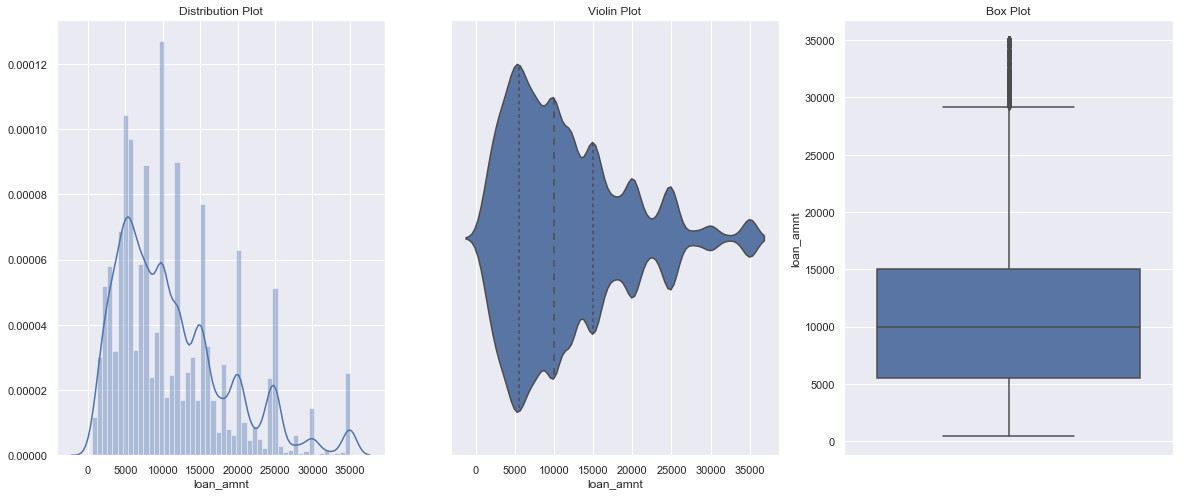

In [24]:
univariate(df=loan,col='loan_amnt',vartype=0)

**Insights: Most of the loan amounts are distributed between 5000 to 15000 USD.**

#### 2. Interest Rate

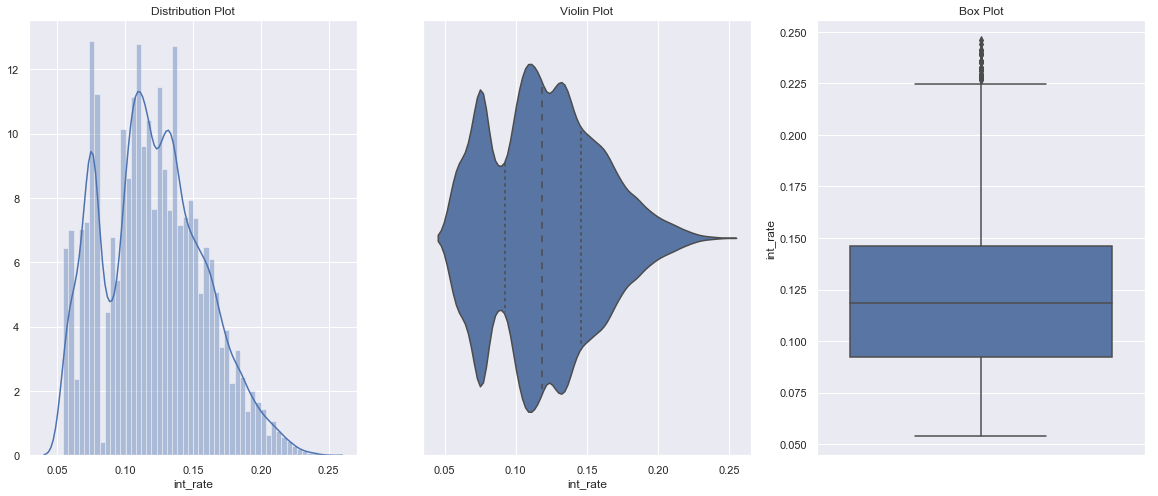

In [25]:
univariate(df=loan,col='int_rate',vartype=0)

**Insights: Most of the loans interest rates are distributed between 10% to 16%.**

#### 3. Annual Income

In [28]:
loan["annual_inc"].describe()

count     39717.0000
mean      68968.9264
std       63793.7658
min        4000.0000
25%       40404.0000
50%       59000.0000
75%       82300.0000
max     6000000.0000
Name: annual_inc, dtype: float64

###### Max value is 6000000 which is approx 80 times more than mean value, so we will remove the outliers from Annual Income.

Remove Outliers (values from 99 to 100%)

In [30]:
q = loan["annual_inc"].quantile(0.995)
loan = loan[loan["annual_inc"] < q]
loan["annual_inc"].describe()

count    39494.0000
mean     66378.2576
std      37413.2123
min       4000.0000
25%      40000.0000
50%      58776.0000
75%      81996.0000
max     294000.0000
Name: annual_inc, dtype: float64

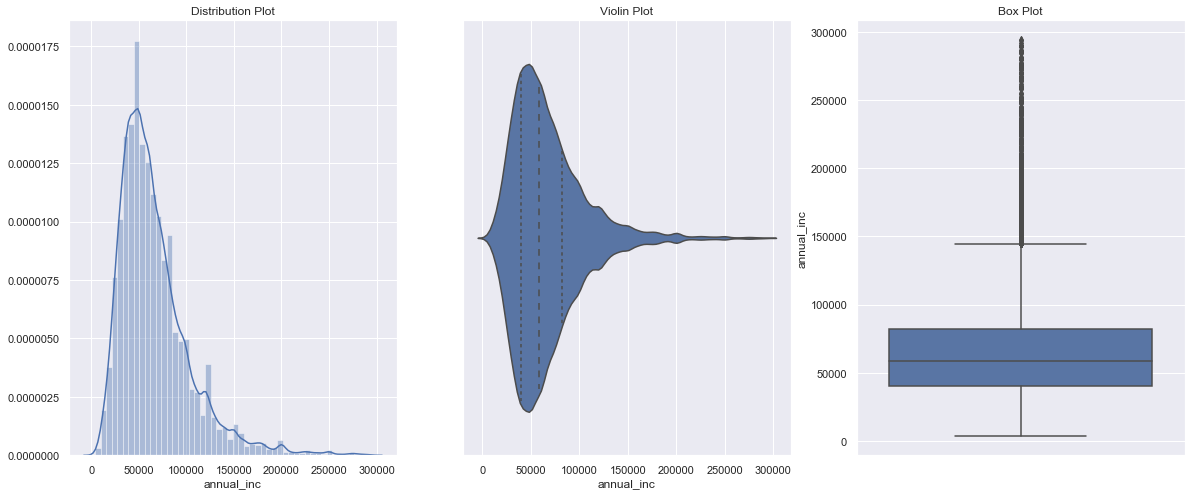

In [31]:
univariate(df=loan,col='annual_inc',vartype=0)

**Insights: Most of the applicants earns beteen 40000 to 90000 USD annually.** 

### Categorical Variables

#### 4. Loan Status

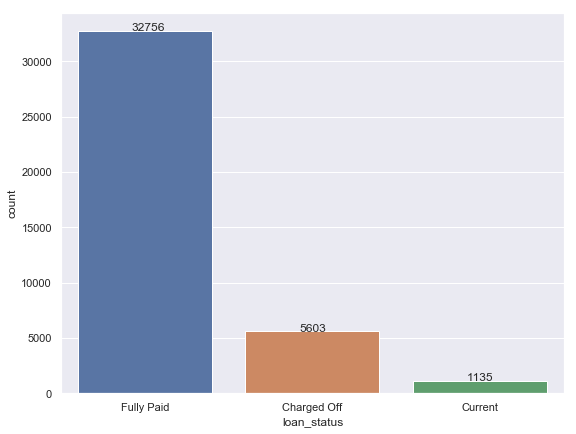

In [33]:
univariate(df=loan,col='loan_status',vartype=1)

**Insights: 14.18% of the applicants Charged off.**

#### 5. Home Ownership wise Loan

In [47]:
loan.home_ownership.unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE'], dtype=object)

In [48]:
# Remove rows where home_ownership'=='OTHER', 'NONE', 'ANY'
rem = ['OTHER', 'NONE']
loan.drop(loan[loan['home_ownership'].isin(rem)].index,inplace=True)
loan.home_ownership.unique()

array(['RENT', 'OWN', 'MORTGAGE'], dtype=object)

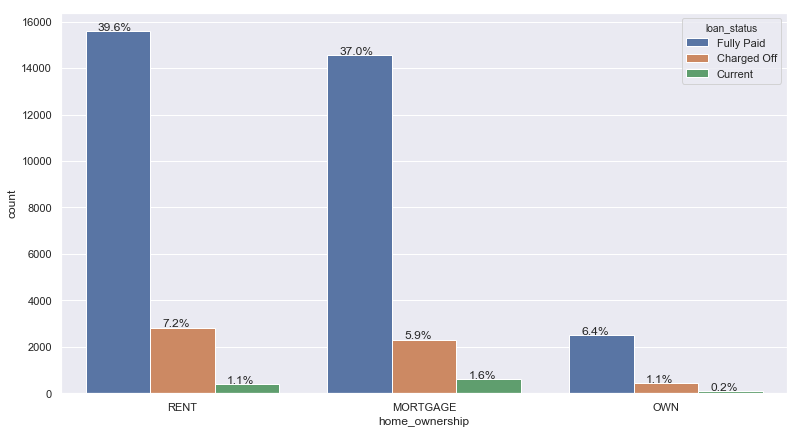

In [57]:
univariate(df=loan,col='home_ownership',vartype=1,hue='loan_status')

**Insights: 48% of applicants are living in rented home whereas 44.5% applicants were mortagaged their home.**

## V. Bivariate/Multivariate Analysis
Bivariate/Multivariate Analysis finds out the relationship between two/two or more variables.We can perform Bivariate/Multivariate analysis for any combination of categorical and continuous variables. The combination can be: Categorical & Categorical, Categorical & Continuous and Continuous & Continuous.

#### 1. Purpose of Loan vs Loan Amount for each Loan Status

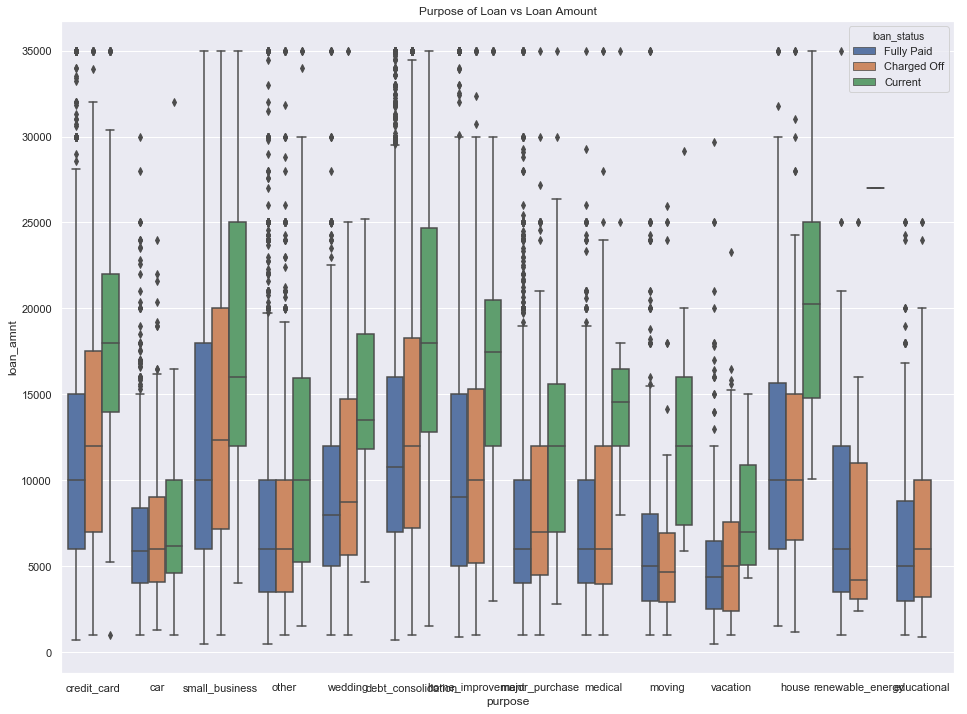

In [61]:
plt.figure(figsize=(16,12))
sns.boxplot(data =loan, x='purpose', y='loan_amnt', hue ='loan_status')
plt.title('Purpose of Loan vs Loan Amount')
plt.show()

#### 2. Correlation Matrix : All Continuos(Numeric) Variables

In [62]:
loan_correlation = loan.corr()
loan_correlation

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt
loan_amnt,1.0000,0.9817,0.9405,0.3077,0.9301,0.4179,0.0717,-0.0342,0.0069,0.1753,-0.0505,0.3148,0.2529,0.1948,0.1945,0.8861,0.8540,0.8510,0.7299,0.0446,0.1366,0.0733,0.4482
funded_amnt,0.9817,1.0000,0.9587,0.3114,0.9559,0.4136,0.0713,-0.0340,0.0073,0.1733,-0.0513,0.3072,0.2468,0.1968,0.1965,0.9026,0.8704,0.8691,0.7377,0.0466,0.1374,0.0751,0.4526
funded_amnt_inv,0.9405,0.9587,1.0000,0.3056,0.9052,0.3963,0.0791,-0.0397,-0.0070,0.1609,-0.0524,0.2884,0.2392,0.2054,0.2054,0.8807,0.9126,0.8449,0.7307,0.0270,0.1248,0.0606,0.4428
int_rate,0.3077,0.3114,0.3056,1.0000,0.2815,0.0769,0.1135,0.1568,0.1332,0.0078,0.0981,0.0936,-0.0472,0.1350,0.1350,0.3065,0.3021,0.1847,0.5293,0.0934,0.1236,0.0680,0.1556
installment,0.9301,0.9559,0.9052,0.2815,1.0000,0.4172,0.0596,-0.0219,0.0075,0.1706,-0.0455,0.3087,0.2265,0.1267,0.1266,0.8563,0.8170,0.8497,0.6347,0.0562,0.1191,0.0758,0.4010
annual_inc,0.4179,0.4136,0.3963,0.0769,0.4172,1.0000,-0.1181,0.0300,0.0364,0.2548,-0.0228,0.4253,0.3689,0.0619,0.0617,0.3977,0.3828,0.3996,0.2859,0.0126,0.0375,0.0234,0.2177
dti,0.0717,0.0713,0.0791,0.1135,0.0596,-0.1181,1.0000,-0.0335,0.0037,0.2907,-0.0051,0.2387,0.2342,0.0363,0.0362,0.0700,0.0765,0.0463,0.1106,-0.0114,0.0254,0.0120,0.0081
delinq_2yrs,-0.0342,-0.0340,-0.0397,0.1568,-0.0219,0.0300,-0.0335,1.0000,0.0075,0.0118,0.0083,-0.0573,0.0669,-0.0030,-0.0032,-0.0245,-0.0306,-0.0407,0.0219,0.0319,0.0121,0.0132,-0.0141
inq_last_6mths,0.0069,0.0073,-0.0070,0.1332,0.0075,0.0364,0.0037,0.0075,1.0000,0.0910,0.0257,-0.0242,0.1100,-0.0117,-0.0114,-0.0127,-0.0220,-0.0259,0.0211,0.0304,0.0194,0.0126,0.0271
open_acc,0.1753,0.1733,0.1609,0.0078,0.1706,0.2548,0.2907,0.0118,0.0910,1.0000,0.0010,0.2888,0.6864,0.0289,0.0287,0.1605,0.1509,0.1588,0.1221,-0.0196,0.0159,0.0057,0.0783


#### 3. HeatMap: All continuos variables

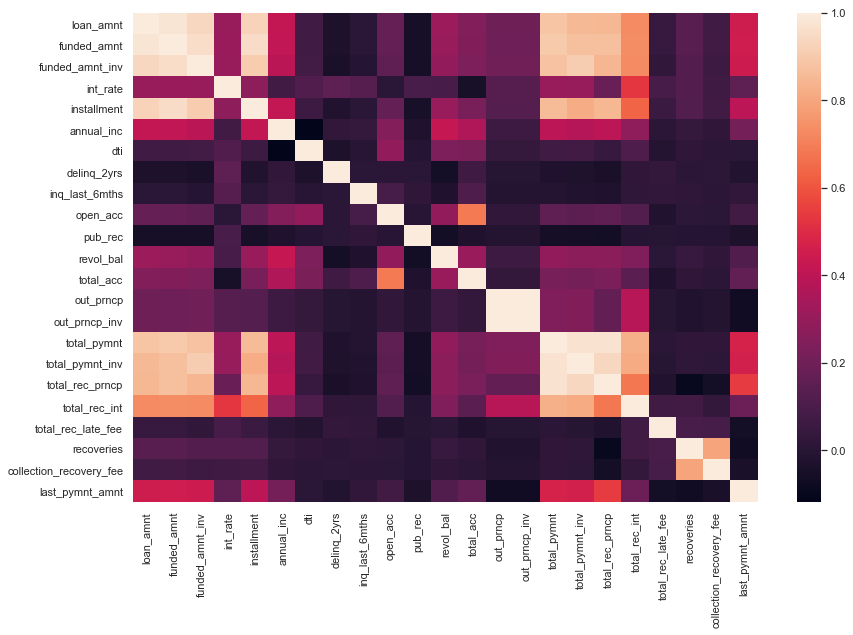

In [64]:
f, ax = plt.subplots(figsize=(14, 9))
sns.heatmap(loan_correlation, 
            xticklabels=loan_correlation.columns.values,
            yticklabels=loan_correlation.columns.values,annot= False)
plt.show()

**Insights: It is clear from the Heatmap that how 'loan_amnt','funded_amnt' & 'funded_amnt_inv' are closely interrelated.So we can take any one column out of them for our analysis.**

#### 4. Employment Length vs Loan Amount for different pupose of Loan

In [65]:
loanstatus=loan.pivot_table(index=['loan_status','purpose','emp_length'],values='loan_amnt',aggfunc=('count')).reset_index()
loanstatus=loan.loc[loan['loan_status']=='Charged Off']

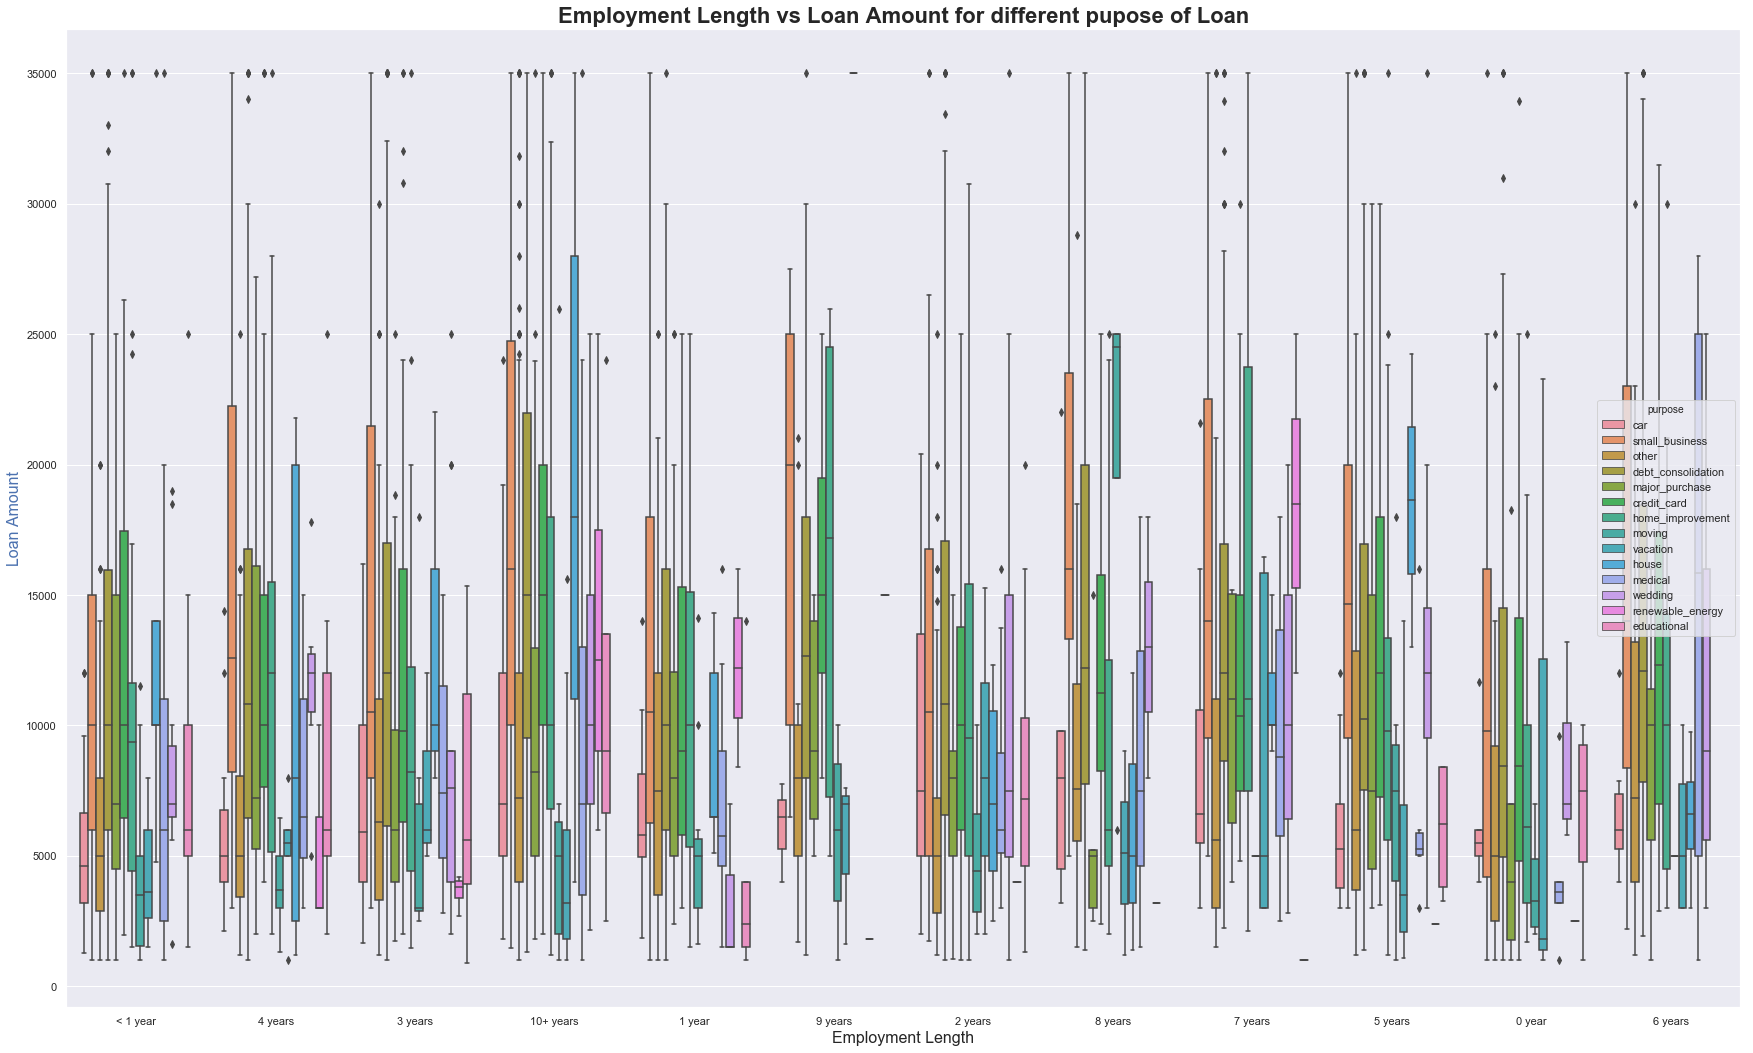

In [66]:
ax = plt.figure(figsize=(30, 18))
ax = sns.boxplot(x='emp_length',y='loan_amnt',hue='purpose',data=loanstatus)
ax.set_title('Employment Length vs Loan Amount for different pupose of Loan',fontsize=22,weight="bold")
ax.set_xlabel('Employment Length',fontsize=16)
ax.set_ylabel('Loan Amount',color = 'b',fontsize=16)
plt.show()

## VI. Bivariate/Multivariate Analysis with Probability of Charge off

### Categorical Variables vs Probability of Charged Off

The main motive of this use case to find what parameters are impacting the most on Loan Status that is if a applicant will successfully complete the loan term or will charge off.

So we will be using a new term now <b>Probability of Charged Off</b> that will be equal to :

\begin{equation*}
{Probability\:of\:Charged\:Off =\:}\frac{Number\:of\:Applicants\:who\:charged\:off}{Total\:No.\:of\:Applicants}
\end{equation*}


We will calculate this probability w.r.t each column in bivariate analysis & will see how the Probability of Charged Off changes with these columns.

We will create a user defined function for this.

**UDF: crosstab**
##### 'crosstab' function will be used to get the summarized table for each column(passed as a variable) along with probability of charge off w.r.t that column.

In [67]:
def crosstab(df,col):
    '''
    df : Dataframe
    col: Column Name
    '''
    crosstab = pd.crosstab(df[col], df['loan_status'],margins=True)
    crosstab['Probability_Charged Off'] = round((crosstab['Charged Off']/crosstab['All']),3)
    crosstab = crosstab[0:-1]
    return crosstab

**UDF: </b>bivariate_prob**
##### 'bivariate_prob' function will be used to plot count of values for each column(passed as a variable) stacked across 'loan_status' along with probability of charged off as a line chart.

In [68]:
# Probability of charge off
def bivariate_prob(df,col,stacked= True):
    '''
    df      : Dataframe
    col     : Column Name
    stacked : True(default) for Stacked Bar
    '''
    # get dataframe from crosstab function
    plotCrosstab = crosstab(df,col)
    
    linePlot = plotCrosstab[['Probability_Charged Off']]      
    barPlot =  plotCrosstab.iloc[:,0:2]
    ax = linePlot.plot(figsize=(20,8), marker='o',color = 'b')
    ax2 = barPlot.plot(kind='bar',ax = ax,rot=1,secondary_y=True,stacked=stacked)
    ax.set_title(df[col].name.title()+' vs Probability Charge Off',fontsize=20,weight="bold")
    ax.set_xlabel(df[col].name.title(),fontsize=14)
    ax.set_ylabel('Probability of Charged off',color = 'b',fontsize=14)
    ax2.set_ylabel('Number of Applicants',color = 'g',fontsize=14)
    plt.show()

#### 1. Location vs Probability Charge Off

In [69]:
filter_states = loan.addr_state.value_counts()
filter_states = filter_states[(filter_states < 10)]

loan_filter_states = loan.drop(labels = loan[loan.addr_state.isin(filter_states.index)].index)

loan_status,Charged Off,Current,Fully Paid,All,Probability_Charged Off
addr_state,,,,,
NJ,277,59,1495,1831,0.1510
NM,30,5,151,186,0.1610
NV,107,17,368,492,0.2170
NY,491,113,3175,3779,0.1300
OH,153,45,1020,1218,0.1260
OK,40,12,247,299,0.1340
OR,71,16,363,450,0.1580
PA,178,49,1285,1512,0.1180
RI,25,4,166,195,0.1280


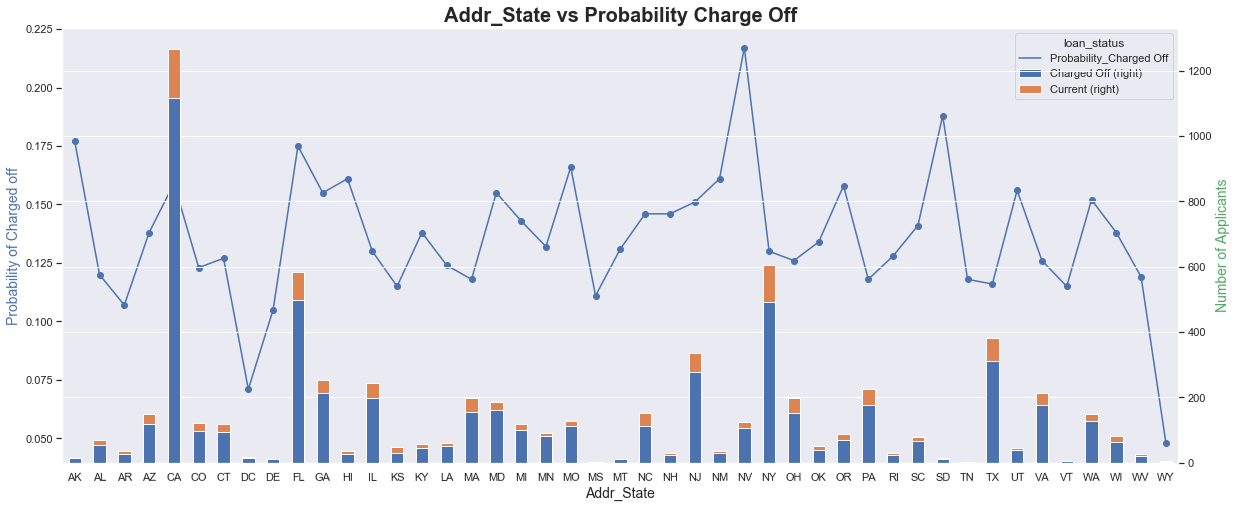

In [70]:
states = crosstab(loan_filter_states,'addr_state')
display(states.tail(20))

bivariate_prob(df =loan_filter_states,col ='addr_state')

**Insights: There are multiple States/Provinces with high probability of charge,highest being 'NV' at 21.2%**

#### 2. Purpose of Loan vs Probability Charge Off

loan_status,Charged Off,Current,Fully Paid,All,Probability_Charged Off
purpose,,,,,
car,159,50,1336,1545,0.1030
credit_card,539,103,4457,5099,0.1060
debt_consolidation,2753,585,15181,18519,0.1490
educational,56,0,265,321,0.1740
home_improvement,340,99,2479,2918,0.1170
house,59,14,301,374,0.1580
major_purchase,220,37,1912,2169,0.1010
medical,106,12,568,686,0.1550
moving,90,7,480,577,0.1560


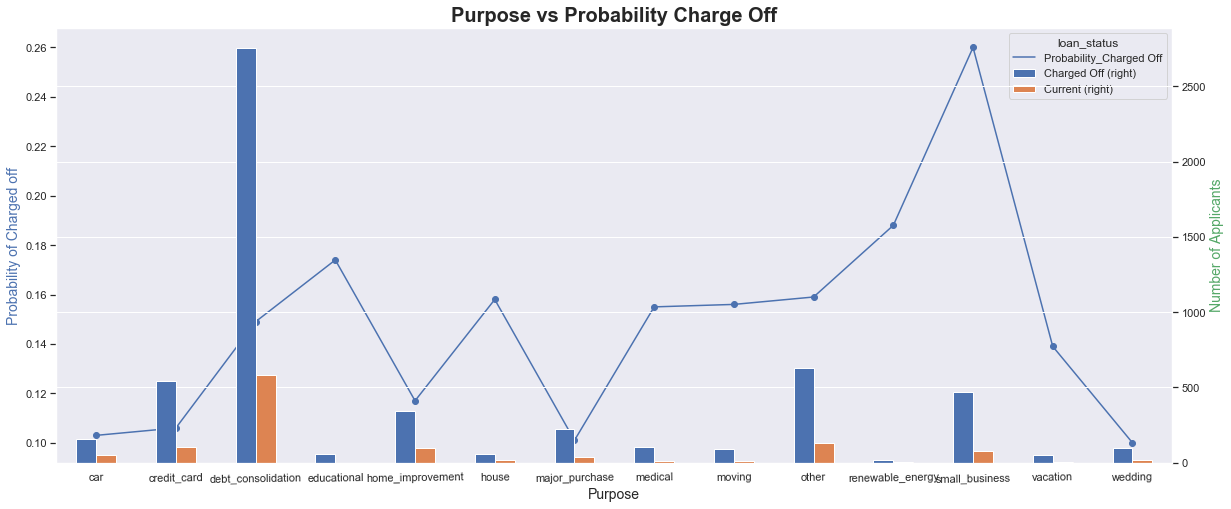

In [71]:
purpose = crosstab(loan,'purpose')
display(purpose)

bivariate_prob(df =loan,col ='purpose',stacked=False)

**Insights: Applicants who has taken the Loan for 'small business' has the highest probabilty of charge off of 26%. So bank should take extra caution like take some asset or guarentee while approving the loan for purpose of 'small business'**  

#### 3. Grade/Subgrade vs Probability Charge Off

loan_status,Charged Off,Current,Fully Paid,All,Probability_Charged Off
grade,,,,,
A,600,40,9386,10026,0.0600
B,1412,345,10176,11933,0.1180
C,1340,262,6429,8031,0.1670
D,1111,220,3929,5260,0.2110
E,708,178,1915,2801,0.2530
F,315,73,648,1036,0.3040
G,99,17,191,307,0.3220


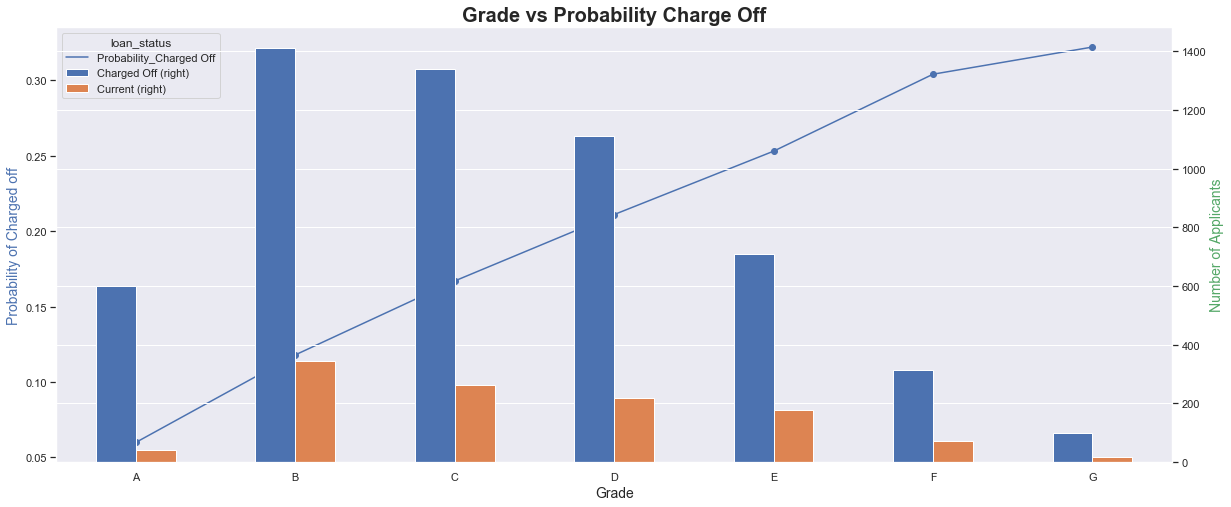

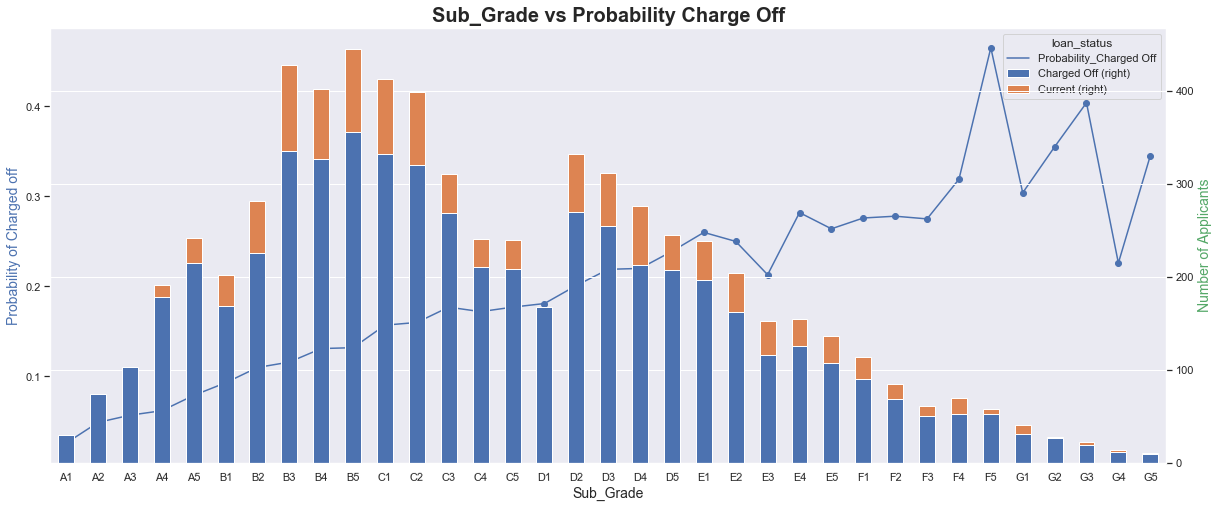

In [72]:
grade = crosstab(loan,'grade')
display(grade)

bivariate_prob(df =loan,col ='grade',stacked=False)
bivariate_prob(df =loan,col ='sub_grade')

**Insights: As we move from Grade A to G, probability that person will charged off is increasing.**      

#### 4. Annual Income Range vs Probability Charge Off

loan_status,Charged Off,Current,Fully Paid,All,Probability_Charged Off
annual_inc_range,,,,,
0-25000,487,26,2056,2569,0.1900
25000-50000,2119,329,10687,13135,0.1610
50000-75000,1679,359,9959,6240,0.2690
75000-100000,733,220,5287,11997,0.0610
100000 and above,567,201,4685,5453,0.1040


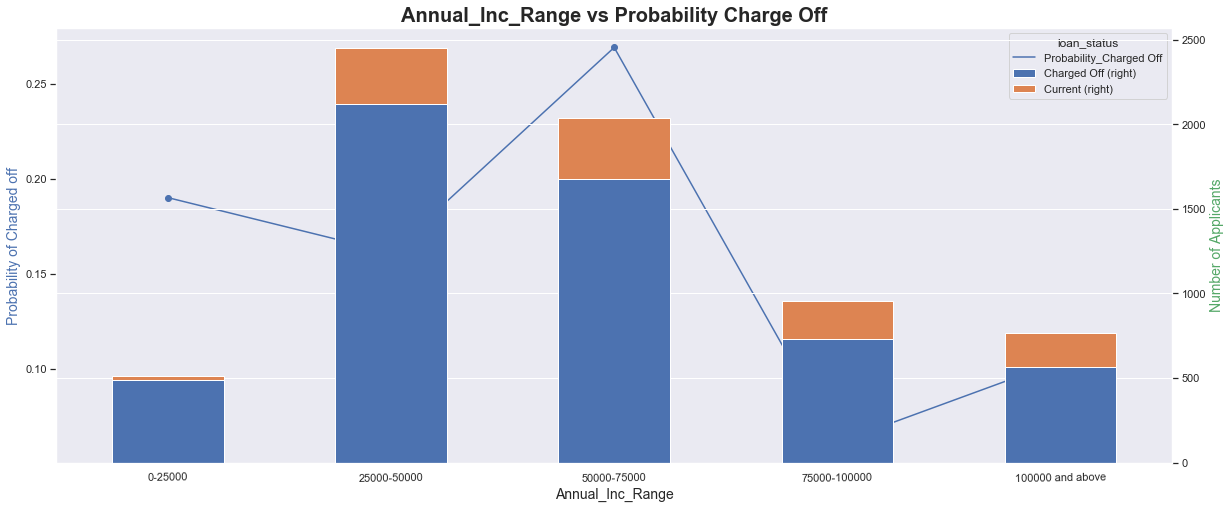

In [74]:
bins = [0, 25000, 50000, 75000, 100000,1000000]
slot = ['0-25000', '25000-50000', '50000-75000', '75000-100000', '100000 and above']
loan['annual_inc_range'] = pd.cut(loan['annual_inc'], bins, labels=slot)
annual_inc_range = crosstab(loan,'annual_inc_range')
display(annual_inc_range)

bivariate_prob(df =loan,col ='annual_inc_range')

**Insights: The probability that person will default is highest of 27% at (50000 to 75000) salary bracket.**     

#### 5. Employment Length vs Probability Charge Off

loan_status,Charged Off,Current,Fully Paid,All,Probability_Charged Off
emp_length,,,,,
0 year,227,42,803,1072,0.2120
1 year,451,71,2685,3207,0.1410
10+ years,1317,389,7071,8777,0.1500
2 years,563,97,3700,4360,0.1290
3 years,550,83,3430,4063,0.1350
4 years,458,94,2865,3417,0.1340
5 years,456,87,2716,3259,0.1400
6 years,305,61,1851,2217,0.1380
7 years,261,62,1440,1763,0.1480


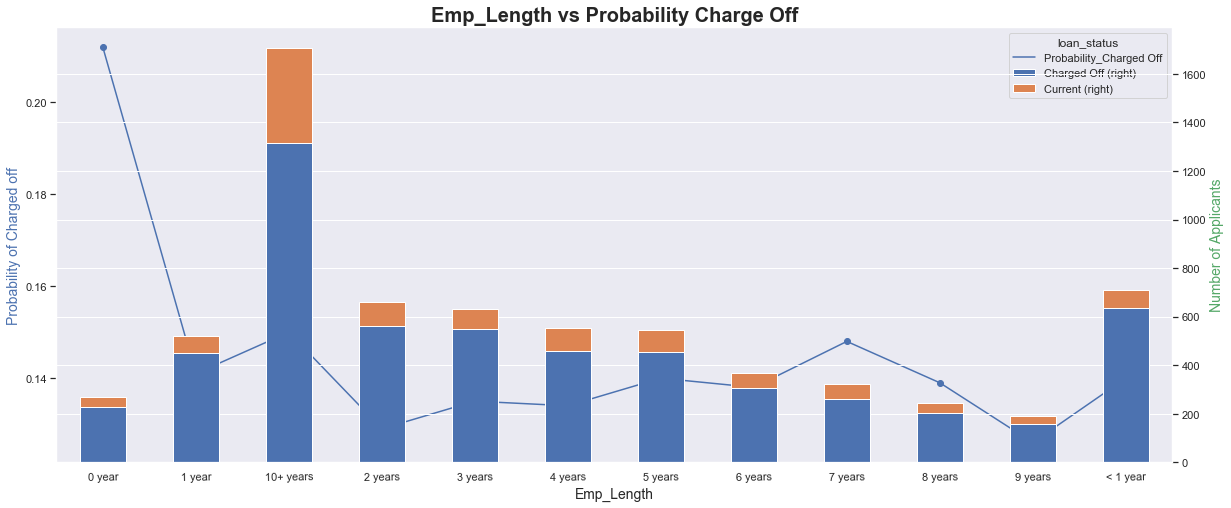

In [77]:
emp_length = crosstab(loan,'emp_length')
display(emp_length)

bivariate_prob(df =loan,col ='emp_length')

**Insights: Applicants who are self employed & less than 1 year of experience are more probable of charged off.**

***
## <font color='blue'><b>VII. Conclusion</b></font> 

### Target Variable
- **Loan Status**

### Top-5 Major variables to consider for loan prediction: 
1. **Purpose of Loan**
2. **Employment Length**
3. **Grade**
4. **Interest Rate**
5. **Term**